In [378]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import preprocessing as prep
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load and clean the data

In [379]:
# Load the data
df = pd.read_csv("./Data/owid-covid-data.csv")

In [380]:
df.sample(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
275842,REU,Africa,Reunion,2020-07-30,657.0,0.0,4.714,3.0,0.0,0.000,...,NaN,NaN,NaN,80.48,NaN,974062.0,NaN,NaN,NaN,NaN
213840,MEX,North America,Mexico,2021-07-22,2699332.0,0.0,11216.429,242896.0,0.0,208.571,...,21.4,87.847,1.38,75.05,0.779,127504120.0,NaN,NaN,NaN,NaN
115602,FRA,Europe,France,2023-02-25,38400087.0,0.0,3445.143,165091.0,0.0,25.714,...,35.6,NaN,5.98,82.66,0.901,67813000.0,NaN,NaN,NaN,NaN
111127,FLK,South America,Falkland Islands,2023-04-09,1923.0,0.0,0.000,NaN,0.0,0.000,...,NaN,NaN,NaN,81.44,NaN,3801.0,NaN,NaN,NaN,NaN
63718,TCD,Africa,Chad,2021-01-25,3137.0,0.0,40.286,116.0,0.0,0.571,...,NaN,5.818,NaN,54.24,0.398,17723312.0,NaN,NaN,NaN,NaN


In [381]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [382]:
columns_to_keep = ['iso_code','location', 'total_cases', 'gdp_per_capita', 'population_density', 'population', 'date']

In [383]:
data = df[columns_to_keep]

In [384]:
data.sample(5)

,iso_code,location,total_cases,gdp_per_capita,population_density,population,date
362587,OWID_UMC,Upper middle income,244733529.0,NaN,NaN,2.525921e+09,2023-12-13
270298,POL,Poland,3346573.0,27216.445,124.027,3.985714e+07,2021-11-22
13631,ARG,Argentina,131.0,18933.907,16.177,4.551032e+07,2020-03-18
214202,MEX,Mexico,6579167.0,17336.469,66.444,1.275041e+08,2022-07-19
152365,IND,India,3542733.0,6426.674,450.419,1.417173e+09,2020-09-04


In [385]:
# get the percentage of missing values
missing_values = (data.isnull().sum()/data.shape[0])*100
missing_values

iso_code               0.000000
location               0.000000
total_cases           10.239973
gdp_per_capita        22.533775
population_density    15.012879
population             0.000000
date                   0.000000
dtype: float64

In [388]:
# remove the rows with missing values in the total_cases column, because we can't get that data from anywhere else
data = data.dropna(subset=['total_cases'])
missing_values = (data.isnull().sum()/data.shape[0])*100
missing_values

iso_code               0.000000
location               0.000000
total_cases            0.000000
gdp_per_capita        20.135519
population_density    12.718264
population             0.000000
date                   0.000000
dtype: float64

In [389]:
# turn the date column into a datetime object
data['date'] = pd.to_datetime(data['date'])

In [390]:
iso_codes = data['iso_code'].unique()
iso_codes

array(['AFG', 'OWID_AFR', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATG',
       'ARG', 'ARM', 'ABW', 'OWID_ASI', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR',
       'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL',
       'BES', 'BIH', 'BWA', 'BRA', 'VGB', 'BRN', 'BGR', 'BFA', 'BDI',
       'KHM', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN',
       'COL', 'COM', 'COG', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW',
       'CYP', 'CZE', 'COD', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY',
       'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'OWID_EUR', 'OWID_EUN',
       'FRO', 'FLK', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'GAB', 'GMB',
       'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM',
       'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'OWID_HIC', 'HND', 'HUN',
       'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA',
       'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'OWID_KOS', 'KWT',
       'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU

In [391]:
iso_codes_owid = data[data['iso_code'].str.contains('OWID')]['iso_code'].unique()
iso_codes_owid

array(['OWID_AFR', 'OWID_ASI', 'OWID_EUR', 'OWID_EUN', 'OWID_HIC',
       'OWID_KOS', 'OWID_LIC', 'OWID_LMC', 'OWID_NAM', 'OWID_OCE',
       'OWID_SAM', 'OWID_UMC', 'OWID_WRL'], dtype=object)

In [392]:
# remove owid extra columns
data = data[~data['iso_code'].str.contains('OWID')]

In [393]:
iso_codes_owid = data[data['iso_code'].str.contains('OWID')]['iso_code'].unique()
iso_codes_owid

array([], dtype=object)

In [394]:
# find any countries that doesnt have any data in the population_density column
missing_population_density = data[data['population_density'].isnull()]['iso_code'].unique()
missing_population_density

array(['AIA', 'BES', 'COK', 'FLK', 'GUF', 'GLP', 'GGY', 'JEY', 'MTQ',
       'MYT', 'MSR', 'NIU', 'PCN', 'REU', 'BLM', 'SHN', 'SPM', 'SSD',
       'SYR', 'TKL', 'VAT', 'WLF'], dtype=object)

In [395]:
# load another dataset to fill in the missing population density
pop_density = pd.read_csv("./Data/population-density.csv")

In [396]:
# get the first year of the dataset
first_year = data['date'].min().year
first_year

2020

In [397]:
# get the last year of the dataset
last_year = data['date'].max().year
last_year

2024

In [398]:
# remove rows that are not within the range of the first and last year of the covid dataset
pop_density = pop_density[pop_density['Year'] >= first_year]
pop_density = pop_density[pop_density['Year'] <= last_year]

In [399]:
pop_density.shape

(1220, 4)

In [400]:
pop_density.sample(5)

,Entity,Code,Year,Population density
38570,Liechtenstein,LIE,2020,242.393750
36544,Laos,LAO,2022,32.623383
41741,Mali,MLI,2023,19.090230
51027,Norway,NOR,2021,14.831851
52981,Panama,PAN,2021,58.658184


In [401]:
(pop_density.isnull().sum()/pop_density.shape[0])*100

Entity                0.000000
Code                  4.508197
Year                  0.000000
Population density    0.000000
dtype: float64

In [402]:
pop_density[pop_density['Code'].isnull()]

,Entity,Code,Year,Population density
595,Africa,NaN,2020,45.474545
596,Africa,NaN,2021,46.577396
597,Africa,NaN,2022,47.682274
598,Africa,NaN,2023,48.810062
599,Africa,NaN,2024,49.963478
3884,Asia,NaN,2020,149.983980
3885,Asia,NaN,2021,150.956790
3886,Asia,NaN,2022,151.859040
3887,Asia,NaN,2023,152.838000
3888,Asia,NaN,2024,153.866350


In [403]:
# remove rows with missing values in the Code column, as they are not useful because they are not associated with any country, but rather a region, continent or group of people
pop_density = pop_density.dropna(subset=['Code'])

In [404]:
(pop_density.isnull().sum()/pop_density.shape[0])*100

Entity                0.0
Code                  0.0
Year                  0.0
Population density    0.0
dtype: float64

In [405]:
len(pop_density['Entity'].unique())

233

In [406]:
pop_density.rename(columns={'Entity':'location', 'Code':'iso_code','Year':'year', 'Population density': 'population_density'}, inplace=True)

In [407]:
pop_density.sample(5)

,location,iso_code,year,population_density
38912,Lithuania,LTU,2024,43.002266
66778,Taiwan,TWN,2022,674.764100
45019,Mongolia,MNG,2023,2.213253
57909,Saint Pierre and Miquelon,SPM,2022,25.586956
2141,Angola,AGO,2021,27.676086


In [408]:
# find out if the countries in the covid dataset, with missing population_density, are in the population density dataset
doesnt_exists = []
for code in missing_population_density:
    if not code in pop_density['iso_code'].unique():
        doesnt_exists.append(code)

print(len(doesnt_exists), len(missing_population_density))
print(doesnt_exists)

5 22
['GGY', 'JEY', 'PCN', 'BLM', 'VAT']


In [409]:
# remove the countries that are not in the population density dataset
data = data[~data['iso_code'].isin(doesnt_exists)]

In [411]:
rows_with_missing_pop_density = data[data['population_density'].isnull()]
df_with_pop_filled = pd.DataFrame(columns=data.columns)
for row in rows_with_missing_pop_density.iterrows():
    index = row[0]
    row = row[1]
    year = row['date'].year
    location = row['location']
    iso_code = row['iso_code']
    year_condition = pop_density['year'] == year
    iso_code_condition = pop_density['iso_code'] == iso_code
    combined_condition = year_condition & iso_code_condition
    pop_density_row = pop_density[combined_condition]
    #print(f"putting data into index: {index}")
    df_with_pop_filled.loc[index] = [iso_code, location, row['total_cases'], row['gdp_per_capita'], pop_density_row['population_density'].values[0], row['population'], row['date']]


In [412]:
data['population_density'] = data['population_density'].fillna(df_with_pop_filled['population_density'])

In [413]:
before_dropping_missing = data.shape[0]
data.shape

(315870, 7)

In [414]:
data = data.dropna(subset=['gdp_per_capita'])

In [415]:
after_dropping_missing = data.shape[0]
data.shape

(269796, 7)

In [416]:
dropped_values = before_dropping_missing - after_dropping_missing
print(f"dropped {dropped_values} rows")

dropped 46074 rows


In [417]:
missing_values = (data.isnull().sum()/data.shape[0])*100
missing_values

iso_code              0.0
location              0.0
total_cases           0.0
gdp_per_capita        0.0
population_density    0.0
population            0.0
date                  0.0
dtype: float64

# Hypotese 1

### Vi tror at der er en sammenhængen mellem antal smittede i forholds til et lands Bruttonationalprodukt (BNP) per indbygger.

In [420]:
# Copy the data to use for hypothesis 1
data_hypothesis_1 = data[['location', 'total_cases', 'gdp_per_capita', 'date']]

In [421]:
# get the last row for each country
last_row = data_hypothesis_1.groupby('location').last().reset_index()
last_row

,location,total_cases,gdp_per_capita,date
0,Afghanistan,231990.0,1803.987,2024-02-18
1,Albania,334863.0,11803.431,2024-02-18
2,Algeria,272010.0,13913.839,2024-02-18
3,Angola,107325.0,5819.495,2024-02-18
4,Antigua and Barbuda,9106.0,21490.943,2024-02-18
...,...,...,...,...
186,Venezuela,552695.0,16745.022,2024-02-18
187,Vietnam,11624000.0,6171.884,2024-02-18
188,Yemen,11945.0,1479.147,2024-02-18
189,Zambia,349304.0,3689.251,2024-02-18


In [422]:
last_row['date'].max() == last_row['date'].min()

True

In [ ]:
def mouse_over_event(event):
    # Iterating over each data member plotted
    for curve in plot.get_lines():
        # Searching which data member corresponds to current mouse position
        if curve.contains(event)[0]:
            print(curve.get_label())

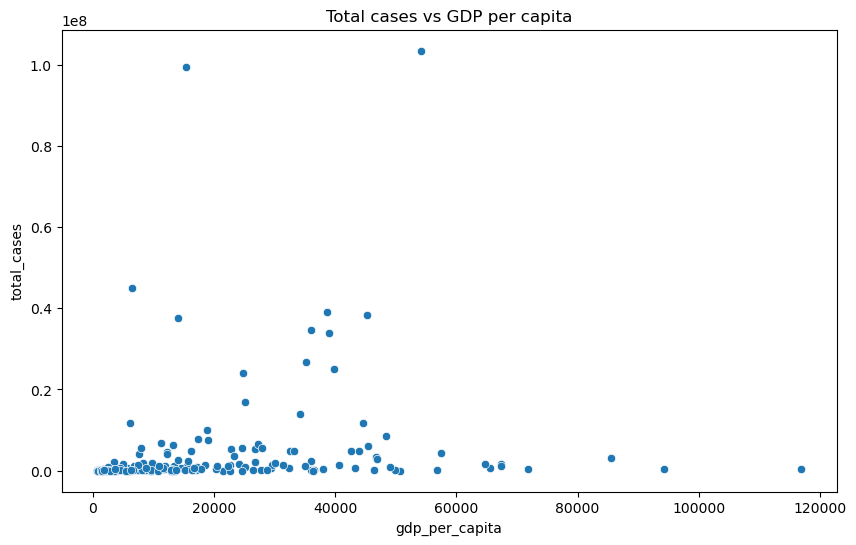

In [423]:
# scatterplot for total_cases and gdp_per_capita for each country
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gdp_per_capita', y='total_cases', data=last_row)
plt.title('Total cases vs GDP per capita')
fig.canvas.mpl_connect('motion_notify_event', lambda event: print())
plt.show()